In [126]:
import albumentations as A
import cv2

rotate     = A.Compose([
        A.Rotate(10, border_mode=cv2.BORDER_REPLICATE, always_apply=True),
    ],
    additional_targets={'image2': 'image'}
)

shear      = A.Compose([
        A.Affine(shear=(-10,10), always_apply=True, mode=1),
    ],
    additional_targets={'image2': 'image'}
)

scale      = A.Compose([
        A.Affine(scale=(0.9,1.1), always_apply=True, mode=1),
    ],
    additional_targets={'image2': 'image'}
)

horizontal = A.Compose([
        A.HorizontalFlip(always_apply=True),
    ],
    additional_targets={'image2': 'image'}
)
elastic    = A.Compose([
        A.ElasticTransform(alpha=1, alpha_affine=10, border_mode=1, always_apply=True),
    ],
    additional_targets={'image2': 'image'}
)
grid       = A.Compose([
        A.GridDistortion(distort_limit=0.2, border_mode=1, always_apply=True),
    ],
    additional_targets={'image2': 'image'}
)

In [10]:
aug_list = [
    rotate,
    shear,
    scale,
    horizontal,
    elastic,
    grid
]
compulsory_aug = A.Compose(
    [
        A.NoOp(always_apply=True)
    ],
    additional_targets={'image2': 'image'}
)

In [5]:
import os 
import numpy as np
from tqdm import tqdm

def augment_images(input_path, compulsory_aug, other_augs, output_path='/home/msc2/DATA/train'):
    input_path_list = [i for i in sorted(os.listdir(input_path)) if 'flair' in i]
    for path in tqdm(input_path_list, 'Images : '):
        full_path = os.path.join(input_path, path)
        full_t1_path    = full_path[:-9] + 't1.npy'
        full_flair_path = full_path
        full_mask_path  = full_path[:-9] + 'mask.npy'
        
        t1        = np.load(full_t1_path)
        flair     = np.load(full_flair_path)
        mask      = np.load(full_mask_path)
        
        # compulsory augs
        dict_ = compulsory_aug(image=flair, image2=t1, mask=mask)
        t1    = dict_['image2']
        flair = dict_['image']
        mask  = dict_['mask']
        
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        
        # saving these transformed images and masks
        file_name = output_path + '/' + path[:-9]
        np.save(file_name + 'aug0_t1.npy', t1)
        np.save(file_name + 'aug0_flair.npy', flair)
        np.save(file_name + 'aug0_mask.npy', mask)
        # other augs
        i=1
        for aug in other_augs:
            dict_ = aug(image=flair, image2=t1, mask=mask)
            t1_aug    = dict_['image2']
            flair_aug = dict_['image']
            mask_aug  = dict_['mask']
            # saving these transformed images and masks
            np.save(file_name + f'aug{i}_t1.npy', t1_aug)
            np.save(file_name + f'aug{i}_flair.npy', flair_aug)
            np.save(file_name + f'aug{i}_mask.npy', mask_aug)
            i+=1

In [140]:
augment_images('/home/msc2/DATA/Slices/train_vbnet', compulsory_aug, aug_list)

Images : 100%|██████████████████████████████| 2968/2968 [02:42<00:00, 18.32it/s]


Text(0.5, 1.0, 'Augmented')

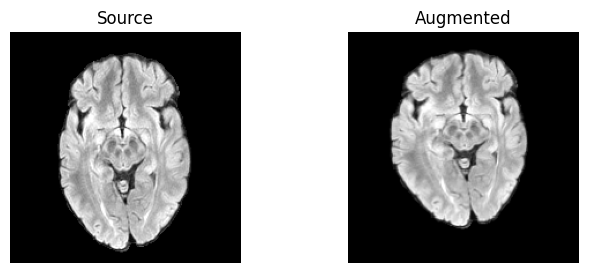

In [139]:
import matplotlib.pyplot as plt
image = np.load('/home/msc2/DATA/Slices/train_vbnet/amst_100_IMG0045_flair.npy')
aug   = grid(image=image)['image']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3), sharex=True, sharey=True)
for aa in (ax1, ax2):
    aa.set_axis_off()

ax1.imshow(image, cmap='gray')
ax1.set_title('Source')
ax2.imshow(aug, cmap='gray')
ax2.set_title('Augmented')

# The End